# Fraud Detection Classifier Notebook

*   **Problem:** Fraud Detection - Binary Classifier
*   **Dataset:** [Synthetic Financial Dataset for Fraud Detection](https://www.kaggle.com/ntnu-testimon/paysim1)
*   **Methods:** An assortment of Networks built using PyTorch
*   **Evaluation:** Accuracy, Precision, Recall, and F1 Scores
<!-- *    -->

## Contents

1.   Import Libraries
2.   Load Dataset
3.   Exploratory Data Analysis
4.   Feature Engineering
5.   Network Classes
6.   Training and Testing
7.   Evaluation






# Import Libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import tqdm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load Dataset

Download the data from the kaggle [LINK](https://www.kaggle.com/ntnu-testimon/paysim1) , unzip, and place in the root folder.**bold text**

In [2]:
file_path = 'PS_20174392719_1491204439457_log.csv'
data = pd.read_csv(file_path)

# Exploratory Data Analysis

In [3]:
# Rename faulty column, 
data = data.rename(columns={'oldbalanceOrg': 'oldbalanceOrig'})
data.head()

step      type    amount  ... newbalanceDest  isFraud  isFlaggedFraud
0     1   PAYMENT   9839.64  ...            0.0        0               0
1     1   PAYMENT   1864.28  ...            0.0        0               0
2     1  TRANSFER    181.00  ...            0.0        1               0
3     1  CASH_OUT    181.00  ...            0.0        1               0
4     1   PAYMENT  11668.14  ...            0.0        0               0

[5 rows x 11 columns]

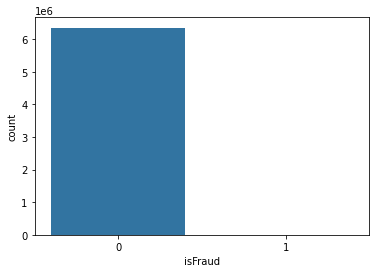

In [4]:
sns.countplot(data['isFraud'])

**There are far more negative samples than postive samples.**

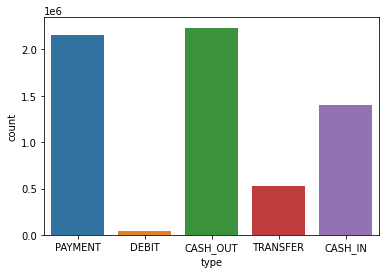

In [5]:
sns.countplot(data[data['isFraud'] == 0]['type'])

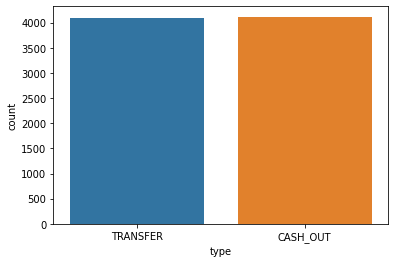

In [6]:
sns.countplot(data[data['isFraud'] == 1]['type'])

**Positve samples of Fraud only occur in two Types: Transfer and Cash-Out**

In [7]:
fraud = data[data['isFraud']==1]
notFraud = data[data['isFraud']==0]

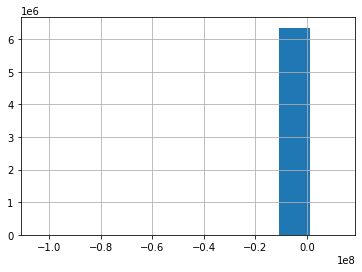

In [8]:
((notFraud['oldbalanceOrig'] - notFraud['newbalanceOrig']) -
 (notFraud['newbalanceDest'] - notFraud['oldbalanceDest'])).hist()

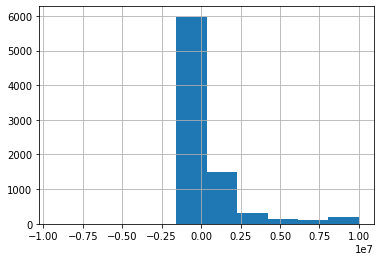

In [9]:
((fraud['oldbalanceOrig'] - fraud['newbalanceOrig']) -
 (fraud['newbalanceDest'] - fraud['oldbalanceDest'])).hist()

**In many cases of Fraud, there is a noticeable positive difference between the difference between Original balance, and the difference between the Destination balance**

# Feature Engineering

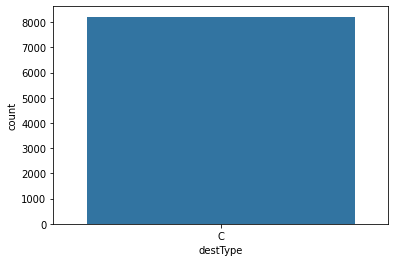

In [10]:
data['destType'] = data['nameDest'].apply(lambda x: x[0])
sns.countplot(data[data['isFraud'] == 1]['destType'])

**Account destinations start with either M or C, so we add this as a feature.**

**Fraud only ever comes from Destination accounts of type C, never type M (for Merchant)**

In [11]:
data['balanceDiff'] = ((data['oldbalanceOrig'] - data['newbalanceOrig']) -
                       (data['newbalanceDest'] - data['oldbalanceDest']))

# Network Classes

## Dataset Class

In [29]:
class Encoder(torch.utils.data.Dataset):
    def __init__(self, dataframe, seed=1):
        # Balancing the dataset
        pos = dataframe[dataframe['isFraud']==1]
        neg = dataframe[dataframe['isFraud']==0].sample(
            len(pos), random_state=seed)
        df = pd.concat([pos, neg])
        # categorical columns into One-Hot vectors
        catCols = ['type', 'destType']
        catVecs = pd.get_dummies(df[catCols]).values
        # continuous columns into Min-Max vectors
        contCols = ['amount', 'balanceDiff']
        scaler = MinMaxScaler()
        contVecs = scaler.fit_transform(df[['amount', 'balanceDiff']])
        # compound vectors
        self.targets = np.hstack([catVecs, contVecs])
        self.labels = df['isFraud'].values
    
    def __getitem__(self, i):
        return self.targets[i, :], self.labels[i]
    
    def __len__(self):
        return len(self.targets)

In [30]:
dataset = Encoder(data)
train_size = int(0.65 * len(dataset))
validation_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - validation_size
train_set, validation_set, test_set = torch.utils.data.random_split(
    dataset, [train_size, validation_size, test_size])

In [31]:
np.random.seed(1)
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=821, shuffle=True)
validation_loader = torch.utils.data.DataLoader(
    validation_set, batch_size=821, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=821, shuffle=True)
data_loaders = {"train": train_loader, "validation": validation_loader}

## Neural Network Class

In [54]:
class NeuralNetClassifier(nn.Module):
    def __init__(self, vec_size, hidden,):
        super(NeuralNetClassifier, self).__init__()
        self.fc1 = nn.Linear(vec_size, hidden)
        self.fc2 = nn.Linear(hidden, 1)
    
    def forward(self, inputs):
        x = F.relu(self.fc1(inputs.squeeze(1).float()))
        return self.fc2(x)

In [55]:
nnc_model = NeuralNetClassifier(9, 3)
nnc_model

NeuralNetClassifier(
  (fc1): Linear(in_features=9, out_features=3, bias=True)
  (fc2): Linear(in_features=3, out_features=1, bias=True)
)

In [56]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam([p for p in nnc_model.parameters() if p.requires_grad],
                       lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')

In [57]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Training and Testing

In [58]:
nnc_model.train()
all_losses = {'train': [], 'validation': []}
n_epochs = 400
for epoch in range(n_epochs):
    losses = {'train': [], 'validation': []}
    for phase in ['train', 'validation']:
        if phase == 'train':
            nnc_model.train(True)
        else:
            nnc_model.train(False)
        
        progress_bar = tqdm.notebook.tqdm(data_loaders[phase], leave=False)
        total = 0
        for inputs, target in progress_bar:
            nnc_model.zero_grad()

            output = nnc_model(inputs)
            loss = criterion(output.squeeze(), target.float())
                
            nn.utils.clip_grad_norm_(nnc_model.parameters(), 3)

            # backward + optimize only if in training phase
            if phase == 'train':
                loss.backward()
                optimizer.step()
            
            progress_bar.set_description(f'Loss: {loss.item():.3f}')
            
            losses[phase].append(loss.item())
            total += 1
    
        epoch_loss = sum(losses[phase]) / total
        all_losses[phase].append(epoch_loss)
    scheduler.step(all_losses['validation'][-1])
                
    # tqdm.write(f'Epoch #{epoch + 1}\tTrain Loss: {all_losses['train'][-1]:.3f}\tValidation Loss: {all_losses['validation'][-1]:.3f}')
    mess = "Epoch #{0}\tTrain Loss: {1:.3f}\tValidation Loss: {2:.3f}".format(
        epoch + 1, all_losses['train'][-1], all_losses['validation'][-1])
    tqdm.tqdm.write(mess)

Epoch #1	Train Loss: 0.746	Validation Loss: 0.745


Epoch #2	Train Loss: 0.733	Validation Loss: 0.732


Epoch #3	Train Loss: 0.721	Validation Loss: 0.717


Epoch #4	Train Loss: 0.719	Validation Loss: 0.703


Epoch #5	Train Loss: 0.695	Validation Loss: 0.687


Epoch #6	Train Loss: 0.670	Validation Loss: 0.673


Epoch #7	Train Loss: 0.666	Validation Loss: 0.660


Epoch #8	Train Loss: 0.663	Validation Loss: 0.647


Epoch #9	Train Loss: 0.636	Validation Loss: 0.634


Epoch #10	Train Loss: 0.632	Validation Loss: 0.621


Epoch #11	Train Loss: 0.629	Validation Loss: 0.609


Epoch #12	Train Loss: 0.601	Validation Loss: 0.598


Epoch #13	Train Loss: 0.595	Validation Loss: 0.587


Epoch #14	Train Loss: 0.584	Validation Loss: 0.576


Epoch #15	Train Loss: 0.578	Validation Loss: 0.566


Epoch #16	Train Loss: 0.573	Validation Loss: 0.557


Epoch #17	Train Loss: 0.557	Validation Loss: 0.548


Epoch #18	Train Loss: 0.552	Validation Loss: 0.540


Epoch #19	Train Loss: 0.537	Validation Loss: 0.532


Epoch #20	Train Loss: 0.528	Validation Loss: 0.525


Epoch #21	Train Loss: 0.536	Validation Loss: 0.518


Epoch #22	Train Loss: 0.516	Validation Loss: 0.512


Epoch #23	Train Loss: 0.510	Validation Loss: 0.505


Epoch #24	Train Loss: 0.496	Validation Loss: 0.499


Epoch #25	Train Loss: 0.501	Validation Loss: 0.493


Epoch #26	Train Loss: 0.505	Validation Loss: 0.487


Epoch #27	Train Loss: 0.502	Validation Loss: 0.481


Epoch #28	Train Loss: 0.486	Validation Loss: 0.477


Epoch #29	Train Loss: 0.480	Validation Loss: 0.472


Epoch #30	Train Loss: 0.473	Validation Loss: 0.468


Epoch #31	Train Loss: 0.464	Validation Loss: 0.464


Epoch #32	Train Loss: 0.467	Validation Loss: 0.460


Epoch #33	Train Loss: 0.458	Validation Loss: 0.456


Epoch #34	Train Loss: 0.471	Validation Loss: 0.452


Epoch #35	Train Loss: 0.443	Validation Loss: 0.449


Epoch #36	Train Loss: 0.466	Validation Loss: 0.445


Epoch #37	Train Loss: 0.439	Validation Loss: 0.442


Epoch #38	Train Loss: 0.457	Validation Loss: 0.439


Epoch #39	Train Loss: 0.435	Validation Loss: 0.436


Epoch #40	Train Loss: 0.424	Validation Loss: 0.434


Epoch #41	Train Loss: 0.425	Validation Loss: 0.431


Epoch #42	Train Loss: 0.410	Validation Loss: 0.429


Epoch #43	Train Loss: 0.425	Validation Loss: 0.426


Epoch #44	Train Loss: 0.413	Validation Loss: 0.424


Epoch #45	Train Loss: 0.421	Validation Loss: 0.422


Epoch #46	Train Loss: 0.425	Validation Loss: 0.420


Epoch #47	Train Loss: 0.428	Validation Loss: 0.419


Epoch #48	Train Loss: 0.417	Validation Loss: 0.417


Epoch #49	Train Loss: 0.426	Validation Loss: 0.415


Epoch #50	Train Loss: 0.417	Validation Loss: 0.414


Epoch #51	Train Loss: 0.393	Validation Loss: 0.413


Epoch #52	Train Loss: 0.404	Validation Loss: 0.411


Epoch #53	Train Loss: 0.408	Validation Loss: 0.410


Epoch #54	Train Loss: 0.430	Validation Loss: 0.409


Epoch #55	Train Loss: 0.390	Validation Loss: 0.408


Epoch #56	Train Loss: 0.420	Validation Loss: 0.407


Epoch #57	Train Loss: 0.441	Validation Loss: 0.406


Epoch #58	Train Loss: 0.395	Validation Loss: 0.406


Epoch #59	Train Loss: 0.407	Validation Loss: 0.405


Epoch #60	Train Loss: 0.407	Validation Loss: 0.403


Epoch #61	Train Loss: 0.414	Validation Loss: 0.403


Epoch #62	Train Loss: 0.442	Validation Loss: 0.403


Epoch #63	Train Loss: 0.383	Validation Loss: 0.402


Epoch #64	Train Loss: 0.386	Validation Loss: 0.401


Epoch #65	Train Loss: 0.395	Validation Loss: 0.400


Epoch #66	Train Loss: 0.388	Validation Loss: 0.399


Epoch #67	Train Loss: 0.402	Validation Loss: 0.399


Epoch #68	Train Loss: 0.378	Validation Loss: 0.398


Epoch #69	Train Loss: 0.409	Validation Loss: 0.398


Epoch #70	Train Loss: 0.411	Validation Loss: 0.397


Epoch #71	Train Loss: 0.381	Validation Loss: 0.397


Epoch #72	Train Loss: 0.384	Validation Loss: 0.396


Epoch #73	Train Loss: 0.392	Validation Loss: 0.396


Epoch #74	Train Loss: 0.380	Validation Loss: 0.395


Epoch #75	Train Loss: 0.405	Validation Loss: 0.395


Epoch #76	Train Loss: 0.446	Validation Loss: 0.394


Epoch #77	Train Loss: 0.375	Validation Loss: 0.395


Epoch #78	Train Loss: 0.402	Validation Loss: 0.394


Epoch #79	Train Loss: 0.373	Validation Loss: 0.394


Epoch #80	Train Loss: 0.407	Validation Loss: 0.393


Epoch #81	Train Loss: 0.382	Validation Loss: 0.393


Epoch #82	Train Loss: 0.413	Validation Loss: 0.392


Epoch #83	Train Loss: 0.387	Validation Loss: 0.392


Epoch #84	Train Loss: 0.388	Validation Loss: 0.392


Epoch #85	Train Loss: 0.378	Validation Loss: 0.391


Epoch #86	Train Loss: 0.400	Validation Loss: 0.391


Epoch #87	Train Loss: 0.393	Validation Loss: 0.391


Epoch #88	Train Loss: 0.401	Validation Loss: 0.390


Epoch #89	Train Loss: 0.375	Validation Loss: 0.390


Epoch #90	Train Loss: 0.400	Validation Loss: 0.390


Epoch #91	Train Loss: 0.403	Validation Loss: 0.390


Epoch #92	Train Loss: 0.411	Validation Loss: 0.390


Epoch #93	Train Loss: 0.389	Validation Loss: 0.389


Epoch #94	Train Loss: 0.384	Validation Loss: 0.389


Epoch #95	Train Loss: 0.394	Validation Loss: 0.389


Epoch #96	Train Loss: 0.469	Validation Loss: 0.389


Epoch #97	Train Loss: 0.391	Validation Loss: 0.389


Epoch #98	Train Loss: 0.367	Validation Loss: 0.389


Epoch #99	Train Loss: 0.364	Validation Loss: 0.388


Epoch #100	Train Loss: 0.389	Validation Loss: 0.388


Epoch #101	Train Loss: 0.385	Validation Loss: 0.388


Epoch #102	Train Loss: 0.412	Validation Loss: 0.389


Epoch #103	Train Loss: 0.376	Validation Loss: 0.388


Epoch #104	Train Loss: 0.366	Validation Loss: 0.387


Epoch #105	Train Loss: 0.405	Validation Loss: 0.387


Epoch #106	Train Loss: 0.420	Validation Loss: 0.387


Epoch #107	Train Loss: 0.397	Validation Loss: 0.388


Epoch #108	Train Loss: 0.415	Validation Loss: 0.388


Epoch #109	Train Loss: 0.385	Validation Loss: 0.389


Epoch #110	Train Loss: 0.383	Validation Loss: 0.387


Epoch #111	Train Loss: 0.427	Validation Loss: 0.387


Epoch #112	Train Loss: 0.413	Validation Loss: 0.387


Epoch #113	Train Loss: 0.382	Validation Loss: 0.387


Epoch #114	Train Loss: 0.379	Validation Loss: 0.387


Epoch #115	Train Loss: 0.385	Validation Loss: 0.387


Epoch #116	Train Loss: 0.399	Validation Loss: 0.387


Epoch #117	Train Loss: 0.393	Validation Loss: 0.387


Epoch #118	Train Loss: 0.397	Validation Loss: 0.386


Epoch #119	Train Loss: 0.392	Validation Loss: 0.385


Epoch #120	Train Loss: 0.394	Validation Loss: 0.384


Epoch #121	Train Loss: 0.379	Validation Loss: 0.384


Epoch #122	Train Loss: 0.401	Validation Loss: 0.384


Epoch #123	Train Loss: 0.410	Validation Loss: 0.384


Epoch #124	Train Loss: 0.420	Validation Loss: 0.384


Epoch #125	Train Loss: 0.383	Validation Loss: 0.383


Epoch #126	Train Loss: 0.379	Validation Loss: 0.383


Epoch #127	Train Loss: 0.378	Validation Loss: 0.383


Epoch #128	Train Loss: 0.395	Validation Loss: 0.383


Epoch #129	Train Loss: 0.374	Validation Loss: 0.383


Epoch #130	Train Loss: 0.375	Validation Loss: 0.383


Epoch #131	Train Loss: 0.378	Validation Loss: 0.382


Epoch #132	Train Loss: 0.380	Validation Loss: 0.383


Epoch #133	Train Loss: 0.383	Validation Loss: 0.383


Epoch #134	Train Loss: 0.392	Validation Loss: 0.383


Epoch #135	Train Loss: 0.376	Validation Loss: 0.383


Epoch #136	Train Loss: 0.376	Validation Loss: 0.383


Epoch #137	Train Loss: 0.378	Validation Loss: 0.382


Epoch #138	Train Loss: 0.363	Validation Loss: 0.382


Epoch #139	Train Loss: 0.394	Validation Loss: 0.382


Epoch #140	Train Loss: 0.369	Validation Loss: 0.381


Epoch #141	Train Loss: 0.382	Validation Loss: 0.381


Epoch #142	Train Loss: 0.390	Validation Loss: 0.381


Epoch #143	Train Loss: 0.376	Validation Loss: 0.381


Epoch #144	Train Loss: 0.385	Validation Loss: 0.381


Epoch #145	Train Loss: 0.363	Validation Loss: 0.381


Epoch #146	Train Loss: 0.393	Validation Loss: 0.381


Epoch #147	Train Loss: 0.423	Validation Loss: 0.381


Epoch #148	Train Loss: 0.378	Validation Loss: 0.381


Epoch #149	Train Loss: 0.405	Validation Loss: 0.381


Epoch #150	Train Loss: 0.376	Validation Loss: 0.381


Epoch #151	Train Loss: 0.359	Validation Loss: 0.380


Epoch #152	Train Loss: 0.376	Validation Loss: 0.380


Epoch #153	Train Loss: 0.361	Validation Loss: 0.380


Epoch #154	Train Loss: 0.378	Validation Loss: 0.380


Epoch #155	Train Loss: 0.358	Validation Loss: 0.380


Epoch #156	Train Loss: 0.387	Validation Loss: 0.380


Epoch #157	Train Loss: 0.360	Validation Loss: 0.379


Epoch #158	Train Loss: 0.387	Validation Loss: 0.379


Epoch #159	Train Loss: 0.373	Validation Loss: 0.379


Epoch #160	Train Loss: 0.358	Validation Loss: 0.379


Epoch #161	Train Loss: 0.380	Validation Loss: 0.379


Epoch #162	Train Loss: 0.377	Validation Loss: 0.379


Epoch #163	Train Loss: 0.374	Validation Loss: 0.379


Epoch #164	Train Loss: 0.404	Validation Loss: 0.379


Epoch #165	Train Loss: 0.392	Validation Loss: 0.380


Epoch #166	Train Loss: 0.402	Validation Loss: 0.381


Epoch #167	Train Loss: 0.374	Validation Loss: 0.381


Epoch #168	Train Loss: 0.403	Validation Loss: 0.380


Epoch #169	Train Loss: 0.382	Validation Loss: 0.380


Epoch #170	Train Loss: 0.376	Validation Loss: 0.379


Epoch #171	Train Loss: 0.357	Validation Loss: 0.378


Epoch #172	Train Loss: 0.373	Validation Loss: 0.378


Epoch #173	Train Loss: 0.385	Validation Loss: 0.378


Epoch #174	Train Loss: 0.376	Validation Loss: 0.378


Epoch #175	Train Loss: 0.353	Validation Loss: 0.378


Epoch #176	Train Loss: 0.368	Validation Loss: 0.378


Epoch #177	Train Loss: 0.368	Validation Loss: 0.377


Epoch #178	Train Loss: 0.371	Validation Loss: 0.377


Epoch #179	Train Loss: 0.352	Validation Loss: 0.377


Epoch #180	Train Loss: 0.403	Validation Loss: 0.377


Epoch #181	Train Loss: 0.370	Validation Loss: 0.378


Epoch #182	Train Loss: 0.388	Validation Loss: 0.377


Epoch #183	Train Loss: 0.355	Validation Loss: 0.377


Epoch #184	Train Loss: 0.375	Validation Loss: 0.376


Epoch #185	Train Loss: 0.355	Validation Loss: 0.377


Epoch #186	Train Loss: 0.383	Validation Loss: 0.377


Epoch #187	Train Loss: 0.373	Validation Loss: 0.377


Epoch #188	Train Loss: 0.432	Validation Loss: 0.377


Epoch #189	Train Loss: 0.373	Validation Loss: 0.377


Epoch #190	Train Loss: 0.368	Validation Loss: 0.377


Epoch #191	Train Loss: 0.402	Validation Loss: 0.376


Epoch #192	Train Loss: 0.379	Validation Loss: 0.376


Epoch #193	Train Loss: 0.408	Validation Loss: 0.375


Epoch #194	Train Loss: 0.368	Validation Loss: 0.375


Epoch #195	Train Loss: 0.352	Validation Loss: 0.375


Epoch #196	Train Loss: 0.420	Validation Loss: 0.375


Epoch #197	Train Loss: 0.396	Validation Loss: 0.376


Epoch #198	Train Loss: 0.350	Validation Loss: 0.376


Epoch #199	Train Loss: 0.395	Validation Loss: 0.375


Epoch #200	Train Loss: 0.416	Validation Loss: 0.375


Epoch #201	Train Loss: 0.382	Validation Loss: 0.376


Epoch #202	Train Loss: 0.387	Validation Loss: 0.375


Epoch #203	Train Loss: 0.389	Validation Loss: 0.375


Epoch #204	Train Loss: 0.394	Validation Loss: 0.374


Epoch #205	Train Loss: 0.361	Validation Loss: 0.375


Epoch #206	Train Loss: 0.350	Validation Loss: 0.375


Epoch #207	Train Loss: 0.363	Validation Loss: 0.374


Epoch #208	Train Loss: 0.382	Validation Loss: 0.374


Epoch #209	Train Loss: 0.386	Validation Loss: 0.374


Epoch #210	Train Loss: 0.376	Validation Loss: 0.375


Epoch #211	Train Loss: 0.366	Validation Loss: 0.374


Epoch #212	Train Loss: 0.394	Validation Loss: 0.374


Epoch #213	Train Loss: 0.351	Validation Loss: 0.374


Epoch #214	Train Loss: 0.369	Validation Loss: 0.374


Epoch #215	Train Loss: 0.352	Validation Loss: 0.374


Epoch #216	Train Loss: 0.366	Validation Loss: 0.373


Epoch #217	Train Loss: 0.367	Validation Loss: 0.373


Epoch #218	Train Loss: 0.356	Validation Loss: 0.373


Epoch #219	Train Loss: 0.373	Validation Loss: 0.373


Epoch #220	Train Loss: 0.368	Validation Loss: 0.373


Epoch #221	Train Loss: 0.359	Validation Loss: 0.373


Epoch #222	Train Loss: 0.366	Validation Loss: 0.372


Epoch #223	Train Loss: 0.369	Validation Loss: 0.373


Epoch #224	Train Loss: 0.384	Validation Loss: 0.372


Epoch #225	Train Loss: 0.371	Validation Loss: 0.373


Epoch #226	Train Loss: 0.348	Validation Loss: 0.374


Epoch #227	Train Loss: 0.377	Validation Loss: 0.373


Epoch #228	Train Loss: 0.383	Validation Loss: 0.372


Epoch #229	Train Loss: 0.397	Validation Loss: 0.372


Epoch #230	Train Loss: 0.368	Validation Loss: 0.372


Epoch #231	Train Loss: 0.372	Validation Loss: 0.373


Epoch #232	Train Loss: 0.366	Validation Loss: 0.373


Epoch #233	Train Loss: 0.364	Validation Loss: 0.372


Epoch #234	Train Loss: 0.363	Validation Loss: 0.372


Epoch #235	Train Loss: 0.369	Validation Loss: 0.371


Epoch #236	Train Loss: 0.368	Validation Loss: 0.371


Epoch #237	Train Loss: 0.362	Validation Loss: 0.371


Epoch #238	Train Loss: 0.361	Validation Loss: 0.371


Epoch #239	Train Loss: 0.397	Validation Loss: 0.371


Epoch #240	Train Loss: 0.376	Validation Loss: 0.371


Epoch #241	Train Loss: 0.386	Validation Loss: 0.371


Epoch #242	Train Loss: 0.361	Validation Loss: 0.372


Epoch #243	Train Loss: 0.367	Validation Loss: 0.371


Epoch #244	Train Loss: 0.394	Validation Loss: 0.371


Epoch #245	Train Loss: 0.366	Validation Loss: 0.371


Epoch #246	Train Loss: 0.378	Validation Loss: 0.370


Epoch #247	Train Loss: 0.379	Validation Loss: 0.370


Epoch #248	Train Loss: 0.374	Validation Loss: 0.370


Epoch #249	Train Loss: 0.369	Validation Loss: 0.370


Epoch #250	Train Loss: 0.400	Validation Loss: 0.370


Epoch #251	Train Loss: 0.394	Validation Loss: 0.372


Epoch #252	Train Loss: 0.379	Validation Loss: 0.373


Epoch #253	Train Loss: 0.366	Validation Loss: 0.371


Epoch #254	Train Loss: 0.392	Validation Loss: 0.371


Epoch #255	Train Loss: 0.394	Validation Loss: 0.370


Epoch #256	Train Loss: 0.351	Validation Loss: 0.370


Epoch #257	Train Loss: 0.345	Validation Loss: 0.369


Epoch #258	Train Loss: 0.363	Validation Loss: 0.369


Epoch #259	Train Loss: 0.378	Validation Loss: 0.369


Epoch #260	Train Loss: 0.377	Validation Loss: 0.369


Epoch #261	Train Loss: 0.371	Validation Loss: 0.369


Epoch #262	Train Loss: 0.362	Validation Loss: 0.369


Epoch #263	Train Loss: 0.377	Validation Loss: 0.370


Epoch #264	Train Loss: 0.409	Validation Loss: 0.369


Epoch #265	Train Loss: 0.362	Validation Loss: 0.369


Epoch #266	Train Loss: 0.362	Validation Loss: 0.369


Epoch #267	Train Loss: 0.361	Validation Loss: 0.370


Epoch #268	Train Loss: 0.382	Validation Loss: 0.369


Epoch #269	Train Loss: 0.382	Validation Loss: 0.370


Epoch #270	Train Loss: 0.364	Validation Loss: 0.369


Epoch #271	Train Loss: 0.363	Validation Loss: 0.369


Epoch #272	Train Loss: 0.393	Validation Loss: 0.368


Epoch #273	Train Loss: 0.360	Validation Loss: 0.368


Epoch #274	Train Loss: 0.366	Validation Loss: 0.368


Epoch #275	Train Loss: 0.367	Validation Loss: 0.368


Epoch #276	Train Loss: 0.394	Validation Loss: 0.368


Epoch #277	Train Loss: 0.370	Validation Loss: 0.368


Epoch #278	Train Loss: 0.378	Validation Loss: 0.368


Epoch #279	Train Loss: 0.368	Validation Loss: 0.367


Epoch #280	Train Loss: 0.350	Validation Loss: 0.367


Epoch #281	Train Loss: 0.347	Validation Loss: 0.367


Epoch #282	Train Loss: 0.359	Validation Loss: 0.367


Epoch #283	Train Loss: 0.378	Validation Loss: 0.367


Epoch #284	Train Loss: 0.363	Validation Loss: 0.368


Epoch #285	Train Loss: 0.413	Validation Loss: 0.369


Epoch #286	Train Loss: 0.376	Validation Loss: 0.367


Epoch #287	Train Loss: 0.377	Validation Loss: 0.367


Epoch #288	Train Loss: 0.365	Validation Loss: 0.367


Epoch #289	Train Loss: 0.401	Validation Loss: 0.367


Epoch #290	Train Loss: 0.440	Validation Loss: 0.367


Epoch #291	Train Loss: 0.430	Validation Loss: 0.367


Epoch #292	Train Loss: 0.347	Validation Loss: 0.368


Epoch #293	Train Loss: 0.348	Validation Loss: 0.367


Epoch #294	Train Loss: 0.373	Validation Loss: 0.367


Epoch #295	Train Loss: 0.363	Validation Loss: 0.366


Epoch #296	Train Loss: 0.389	Validation Loss: 0.366


Epoch #297	Train Loss: 0.375	Validation Loss: 0.366


Epoch #298	Train Loss: 0.362	Validation Loss: 0.367


Epoch #299	Train Loss: 0.362	Validation Loss: 0.367


Epoch #300	Train Loss: 0.342	Validation Loss: 0.366


Epoch #301	Train Loss: 0.350	Validation Loss: 0.366


Epoch #302	Train Loss: 0.357	Validation Loss: 0.366


Epoch #303	Train Loss: 0.425	Validation Loss: 0.366


Epoch #304	Train Loss: 0.356	Validation Loss: 0.366


Epoch #305	Train Loss: 0.377	Validation Loss: 0.366


Epoch #306	Train Loss: 0.351	Validation Loss: 0.367


Epoch #307	Train Loss: 0.405	Validation Loss: 0.366


Epoch #308	Train Loss: 0.376	Validation Loss: 0.366


Epoch #309	Train Loss: 0.362	Validation Loss: 0.366


Epoch #310	Train Loss: 0.360	Validation Loss: 0.365


Epoch #311	Train Loss: 0.395	Validation Loss: 0.365


Epoch #312	Train Loss: 0.359	Validation Loss: 0.365


Epoch #313	Train Loss: 0.382	Validation Loss: 0.365


Epoch #314	Train Loss: 0.416	Validation Loss: 0.365


Epoch #315	Train Loss: 0.399	Validation Loss: 0.365


Epoch #316	Train Loss: 0.355	Validation Loss: 0.366


Epoch #317	Train Loss: 0.374	Validation Loss: 0.366


Epoch #318	Train Loss: 0.355	Validation Loss: 0.365


Epoch #319	Train Loss: 0.348	Validation Loss: 0.365


Epoch #320	Train Loss: 0.357	Validation Loss: 0.365


Epoch #321	Train Loss: 0.393	Validation Loss: 0.364


Epoch #322	Train Loss: 0.391	Validation Loss: 0.366


Epoch #323	Train Loss: 0.385	Validation Loss: 0.365


Epoch #324	Train Loss: 0.377	Validation Loss: 0.364


Epoch #325	Train Loss: 0.365	Validation Loss: 0.365


Epoch #326	Train Loss: 0.377	Validation Loss: 0.365


Epoch #327	Train Loss: 0.361	Validation Loss: 0.364


Epoch #328	Train Loss: 0.392	Validation Loss: 0.364


Epoch #329	Train Loss: 0.343	Validation Loss: 0.364


Epoch #330	Train Loss: 0.347	Validation Loss: 0.364


Epoch #331	Train Loss: 0.360	Validation Loss: 0.364


Epoch #332	Train Loss: 0.413	Validation Loss: 0.364


Epoch #333	Train Loss: 0.374	Validation Loss: 0.364


Epoch #334	Train Loss: 0.358	Validation Loss: 0.365


Epoch #335	Train Loss: 0.360	Validation Loss: 0.364


Epoch #336	Train Loss: 0.339	Validation Loss: 0.364


Epoch #337	Train Loss: 0.360	Validation Loss: 0.363


Epoch #338	Train Loss: 0.375	Validation Loss: 0.364


Epoch #339	Train Loss: 0.361	Validation Loss: 0.365


Epoch #340	Train Loss: 0.355	Validation Loss: 0.365


Epoch #341	Train Loss: 0.402	Validation Loss: 0.365


Epoch #342	Train Loss: 0.358	Validation Loss: 0.364


Epoch #343	Train Loss: 0.357	Validation Loss: 0.363


Epoch #344	Train Loss: 0.371	Validation Loss: 0.364


Epoch #345	Train Loss: 0.387	Validation Loss: 0.365


Epoch #346	Train Loss: 0.355	Validation Loss: 0.364


Epoch #347	Train Loss: 0.358	Validation Loss: 0.363


Epoch #348	Train Loss: 0.364	Validation Loss: 0.363


Epoch #349	Train Loss: 0.394	Validation Loss: 0.363


Epoch #350	Train Loss: 0.387	Validation Loss: 0.365


Epoch #351	Train Loss: 0.358	Validation Loss: 0.365


Epoch #352	Train Loss: 0.360	Validation Loss: 0.364


Epoch #353	Train Loss: 0.343	Validation Loss: 0.363


Epoch #354	Train Loss: 0.343	Validation Loss: 0.362


Epoch #355	Train Loss: 0.366	Validation Loss: 0.362


Epoch #356	Train Loss: 0.344	Validation Loss: 0.362


Epoch #357	Train Loss: 0.363	Validation Loss: 0.362


Epoch #358	Train Loss: 0.342	Validation Loss: 0.362


Epoch #359	Train Loss: 0.345	Validation Loss: 0.362


Epoch #360	Train Loss: 0.345	Validation Loss: 0.362


Epoch #361	Train Loss: 0.338	Validation Loss: 0.362


Epoch #362	Train Loss: 0.405	Validation Loss: 0.362


Epoch #363	Train Loss: 0.348	Validation Loss: 0.362


Epoch #364	Train Loss: 0.360	Validation Loss: 0.362


Epoch #365	Train Loss: 0.360	Validation Loss: 0.362


Epoch #366	Train Loss: 0.357	Validation Loss: 0.362


Epoch #367	Train Loss: 0.375	Validation Loss: 0.362


Epoch #368	Train Loss: 0.387	Validation Loss: 0.362


Epoch #369	Train Loss: 0.342	Validation Loss: 0.363


Epoch #370	Train Loss: 0.340	Validation Loss: 0.362


Epoch #371	Train Loss: 0.339	Validation Loss: 0.362


Epoch #372	Train Loss: 0.364	Validation Loss: 0.362


Epoch #373	Train Loss: 0.399	Validation Loss: 0.362


Epoch #374	Train Loss: 0.394	Validation Loss: 0.362


Epoch #375	Train Loss: 0.357	Validation Loss: 0.362


Epoch #376	Train Loss: 0.343	Validation Loss: 0.362


Epoch #377	Train Loss: 0.369	Validation Loss: 0.362


Epoch #378	Train Loss: 0.374	Validation Loss: 0.361


Epoch #379	Train Loss: 0.346	Validation Loss: 0.362


Epoch #380	Train Loss: 0.368	Validation Loss: 0.362


Epoch #381	Train Loss: 0.350	Validation Loss: 0.361


Epoch #382	Train Loss: 0.343	Validation Loss: 0.361


Epoch #383	Train Loss: 0.355	Validation Loss: 0.361


Epoch #384	Train Loss: 0.361	Validation Loss: 0.361


Epoch #385	Train Loss: 0.340	Validation Loss: 0.361


Epoch #386	Train Loss: 0.368	Validation Loss: 0.361


Epoch #387	Train Loss: 0.336	Validation Loss: 0.361


Epoch #388	Train Loss: 0.350	Validation Loss: 0.361


Epoch #389	Train Loss: 0.373	Validation Loss: 0.360


Epoch #390	Train Loss: 0.399	Validation Loss: 0.360


Epoch #391	Train Loss: 0.373	Validation Loss: 0.360


Epoch #392	Train Loss: 0.357	Validation Loss: 0.360


Epoch #393	Train Loss: 0.386	Validation Loss: 0.360


Epoch #394	Train Loss: 0.361	Validation Loss: 0.360


Epoch #395	Train Loss: 0.341	Validation Loss: 0.360


Epoch #396	Train Loss: 0.357	Validation Loss: 0.360


Epoch #397	Train Loss: 0.426	Validation Loss: 0.361


Epoch #398	Train Loss: 0.358	Validation Loss: 0.361


Epoch #399	Train Loss: 0.369	Validation Loss: 0.360


Epoch #400	Train Loss: 0.400	Validation Loss: 0.360


## Testing

In [59]:
y_res = []
y_true = []
for inputs, targets in test_loader:
    y_res.extend(list(nnc_model(inputs).flatten()))
    y_true.extend(list(targets.flatten()))

In [60]:
y_translated = [1 if t > 0.5 else 0 for t in y_res]

# Evaluation

In [61]:
from sklearn.metrics import accuracy_score
print("Accuracy Score {0:.3f}".format(accuracy_score(y_true, y_translated)))

Accuracy Score 0.815


In [62]:
from sklearn.metrics import precision_score
precision_score(y_true, y_translated)
print("Precision Score {0:.3f}".format(precision_score(y_true, y_translated)))

Precision Score 0.899


In [63]:
from sklearn.metrics import recall_score
print("Recall Score {0:.3f}".format(recall_score(y_true, y_translated)))

Recall Score 0.702


## Results
Our Neural Network is fairly accurate.
Our Neural Network Classifier has high precision, but low recall. This means that when our Fraud detector detects fraud, it's usually fraud, but it misses a lot of actual fraud cases.